<a href="https://colab.research.google.com/github/juliajgmb/emotion_classifier/blob/main/Classificador_de_Emo%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificador de Emoções
Passos do Projeto:
- Pré-processamento dos dados
- Tokenização e padding
- Codificação dos rótulos
- Criação e treino do modelo
- Avaliação
- Testes com frases novas

Importando Bibliotecas Importantes

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Pré-Processamento dos dados

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp")

print("Path to dataset files:", path)

100%|██████████| 721k/721k [00:00<00:00, 70.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/praveengovi/emotions-dataset-for-nlp/versions/1


In [3]:
# Carregar os arquivos
dados_treino = pd.read_csv(path + "/train.txt", sep=';', header=None)
dados_val = pd.read_csv(path + "/val.txt", sep=';', header=None)
dados_teste = pd.read_csv(path + "/test.txt", sep=';', header=None)


In [4]:
dados_treino.head()

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


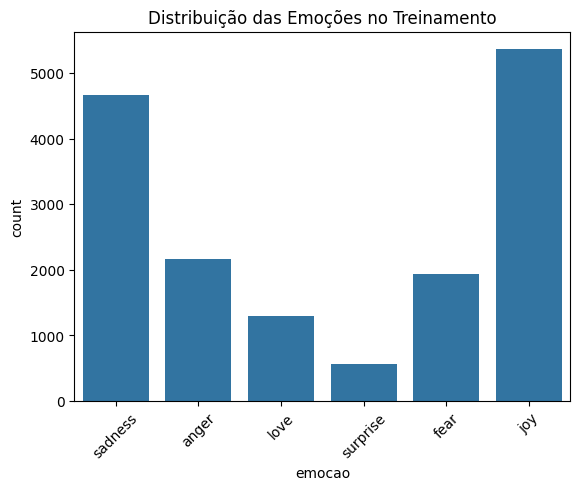

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='emocao', data=dados_treino)
plt.title('Distribuição das Emoções no Treinamento')
plt.xticks(rotation=45)
plt.show()

In [5]:
#Renomeando as colunas
dados_treino.columns = ['texto', 'emocao']
dados_val.columns = ['texto', 'emocao']
dados_teste.columns = ['texto', 'emocao']

print("Value Counts do Treino:",dados_treino['emocao'].value_counts())

Value Counts do Treino: emocao
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


# Tokenização, Padding e Codificação dos Rôtulos

Padding é

Os parâmetros foram setados assim pois:
- vocab_size = 10000: evita que palavras muito raras e diferentes entrem no modelo
- max_length = 50: garante que todas as entradas tenham o mesmo tamanho
- oov_token = "<OOV>": garante que o modelo não quebre ao aparecimento de novas palavras

In [6]:
# Parâmetros
vocab_size = 10000
max_length = 50
oov_token = "<OOV>"

# Criar e treinar o tokenizer apenas com o treino
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(dados_treino['texto'])

# Transformar os textos em sequências
X_train = tokenizer.texts_to_sequences(dados_treino['texto'])
X_val = tokenizer.texts_to_sequences(dados_val['texto'])
X_test = tokenizer.texts_to_sequences(dados_teste['texto'])

# Padding
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [7]:
encoder = LabelEncoder()
encoder.fit(dados_treino['emocao'])  # Fit apenas com os dados de treino

y_train = encoder.transform(dados_treino['emocao'])
y_val = encoder.transform(dados_val['emocao'])
y_test = encoder.transform(dados_teste['emocao'])

num_classes = len(encoder.classes_)
print("Classes:", encoder.classes_)


Classes: ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [8]:
# Criação do modelo
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))  # Camada de embedding
model.add(LSTM(64))  # Camada LSTM
model.add(Dense(64, activation='relu'))  # Camada intermediária
model.add(Dense(num_classes, activation='softmax'))  # Camada de saída com softmax para multi-classes

# Compilar o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualizar o resumo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.9759 - loss: 0.0696 - val_accuracy: 0.9095 - val_loss: 0.3705
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.9822 - loss: 0.0512 - val_accuracy: 0.9050 - val_loss: 0.4173
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9831 - loss: 0.0460 - val_accuracy: 0.9125 - val_loss: 0.3915
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9858 - loss: 0.0375 - val_accuracy: 0.9105 - val_loss: 0.4022
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9889 - loss: 0.0308 - val_accuracy: 0.9190 - val_loss: 0.3661
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9899 - loss: 0.0285 - val_accuracy: 0.9230 - val_loss: 0.4007
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.9919 - loss: 0.0232 - val_accuracy: 0.9145 - val_loss: 0.4267
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9928 - loss: 0.0188 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

       anger       0.96      0.88      0.92       275
        fear       0.88      0.83      0.85       224
         joy       0.90      0.96      0.93       695
        love       0.79      0.73      0.76       159
     sadness       0.95      0.94      0.95       581
    surprise       0.70      0.82      0.76        66

    accuracy                           0.91      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.91      0.91      0.91      2000



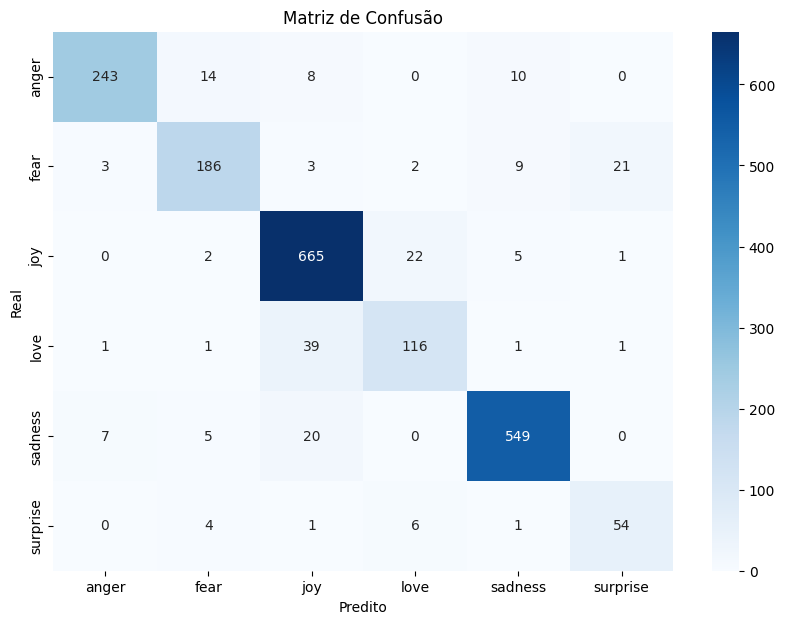

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fazer predições
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Avaliar o modelo
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

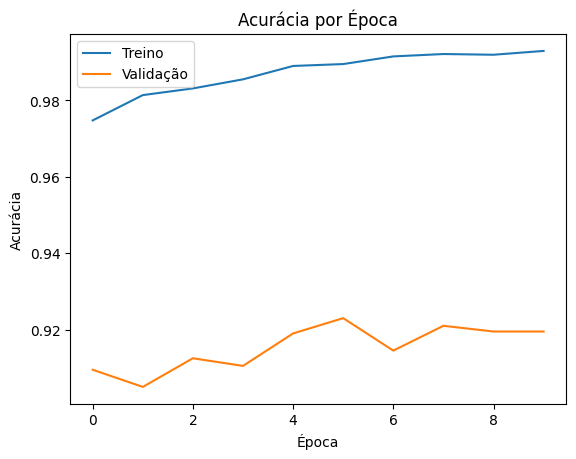

In [17]:
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


O Gráfico nos mostra um Overfitting, por isso vamos seguir os passos para melhora dos dados:

In [22]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))  # ajuda a evitar overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [25]:
history1 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stop])


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.3238 - loss: 1.5918 - val_accuracy: 0.3520 - val_loss: 1.5815
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.3358 - loss: 1.5825 - val_accuracy: 0.3520 - val_loss: 1.5831
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.3400 - loss: 1.5639 - val_accuracy: 0.3815 - val_loss: 1.5036
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.3300 - loss: 1.5846 - val_accuracy: 0.3515 - val_loss: 1.5825
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3438 - loss: 1.5503 - val_accuracy: 0.3820 - val_loss: 1.4067
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.3812 - loss: 1.3548 - val_accuracy: 0.4060 - val_loss: 1.4966
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.4130 - loss: 1.3057 - val_accuracy: 0.4175 - val_loss: 1.2654
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.4376 - loss: 1.2063 - 

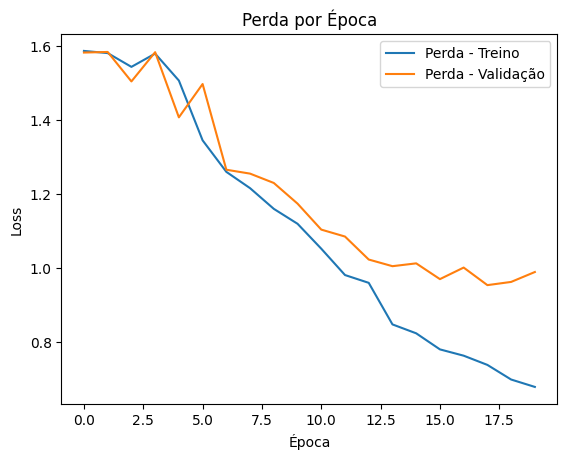

In [26]:
# Gráfico da perda (loss)
plt.plot(history1.history['loss'], label='Perda - Treino')
plt.plot(history1.history['val_loss'], label='Perda - Validação')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

       anger       0.95      0.76      0.84       275
        fear       0.75      0.78      0.77       224
         joy       0.51      0.90      0.65       695
        love       0.51      0.74      0.60       159
     sadness       0.33      0.00      0.00       581
    surprise       0.44      0.59      0.51        66

    accuracy                           0.58      2000
   macro avg       0.58      0.63      0.56      2000
weighted avg       0.54      0.58      0.49      2000



# Nuvem de Palavras

In [18]:
!pip install wordcloud

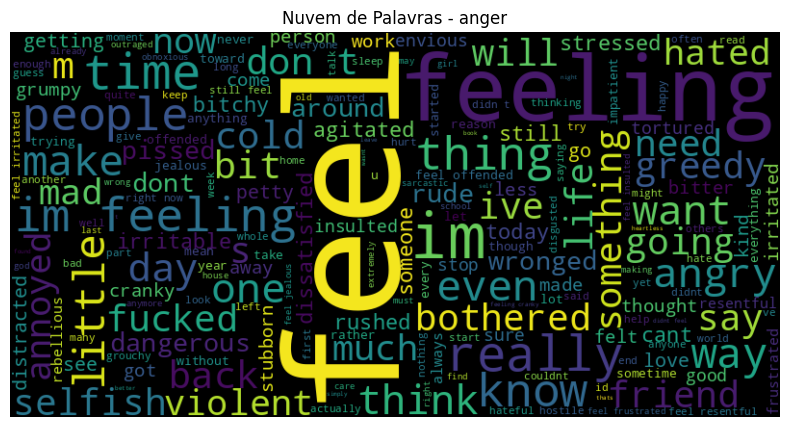

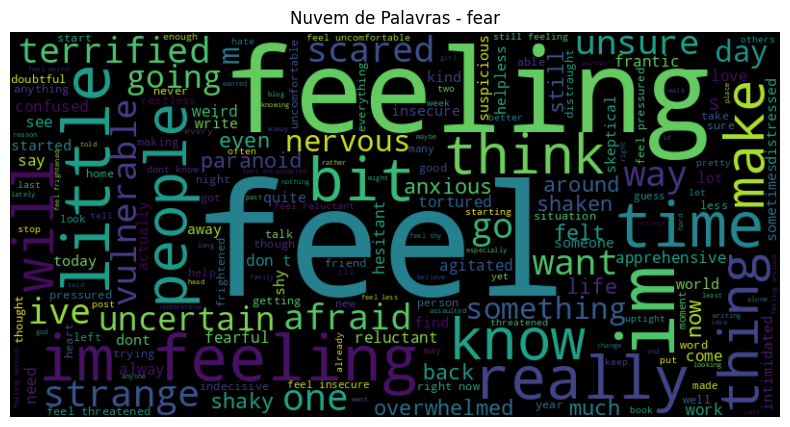

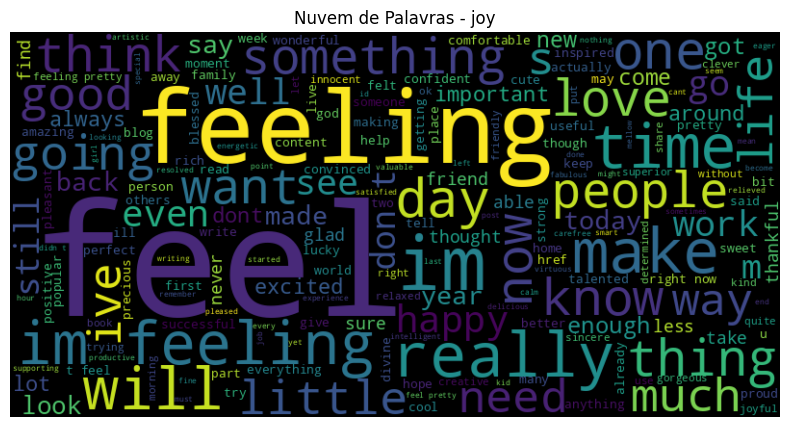

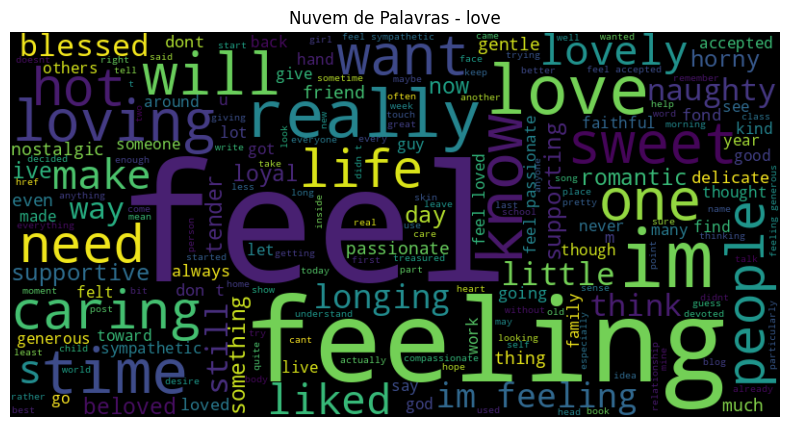

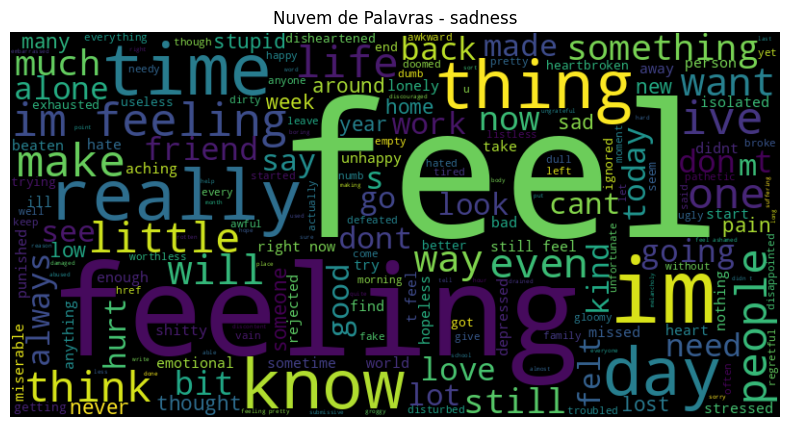

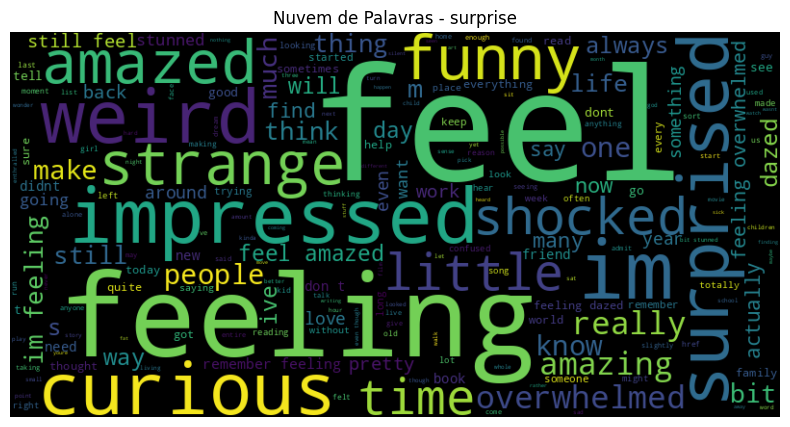

In [20]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# Agrupar os textos por emoção
grupos = dados_treino.groupby('emocao')['texto'].apply(lambda x: ' '.join(x)).reset_index()

stopwords = set(STOPWORDS)
# Gerar uma nuvem para cada emoção
for i, row in grupos.iterrows():
    texto = row['texto']
    emocao = row['emocao']

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(texto)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras - {emocao}')
    plt.show()
